<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:09:07] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


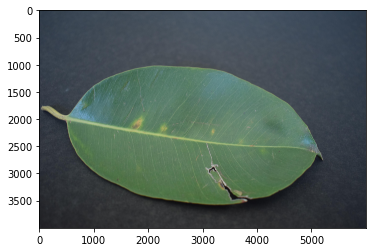

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

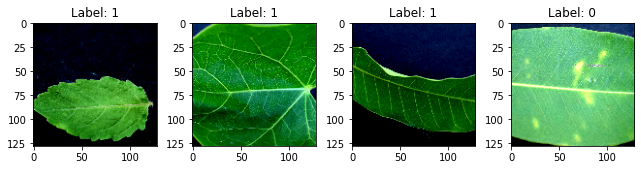

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:09:13] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:09:15] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2419834910191099 samples/sec                   batch loss = 1.8856366872787476 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.2747275691447415 samples/sec                   batch loss = 0.37241852283477783 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.276090978327117 samples/sec                   batch loss = 0.8731188774108887 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2762226062005957 samples/sec                   batch loss = 0.5286545157432556 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.2764979865190704 samples/sec                   batch loss = 0.581318199634552 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.282639317706135 samples/sec                   batch loss = 0.5266447067260742 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.279962110496607 samples/sec                   batch loss = 0.6185176968574524 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.2780406990199198 samples/sec                   batch loss = 0.5963963866233826 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2774364920006491 samples/sec                   batch loss = 0.6030697226524353 | accuracy = 0.5833333333333334


Epoch[1] Batch[50] Speed: 1.2862124280084501 samples/sec                   batch loss = 1.0809080600738525 | accuracy = 0.6


Epoch[1] Batch[55] Speed: 1.2791844067316394 samples/sec                   batch loss = 0.8145396709442139 | accuracy = 0.6045454545454545


Epoch[1] Batch[60] Speed: 1.278799077008141 samples/sec                   batch loss = 0.4081162214279175 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2806008678693692 samples/sec                   batch loss = 0.49764370918273926 | accuracy = 0.6384615384615384


Epoch[1] Batch[70] Speed: 1.2781007714290524 samples/sec                   batch loss = 0.3311631381511688 | accuracy = 0.6428571428571429


Epoch[1] Batch[75] Speed: 1.272251295401618 samples/sec                   batch loss = 0.7835298180580139 | accuracy = 0.6433333333333333


Epoch[1] Batch[80] Speed: 1.2829586785871623 samples/sec                   batch loss = 0.9257186651229858 | accuracy = 0.640625


Epoch[1] Batch[85] Speed: 1.2874758308820167 samples/sec                   batch loss = 0.30706676840782166 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.281968060402788 samples/sec                   batch loss = 0.8223371505737305 | accuracy = 0.6305555555555555


Epoch[1] Batch[95] Speed: 1.2863904373586834 samples/sec                   batch loss = 0.7718194723129272 | accuracy = 0.6263157894736842


Epoch[1] Batch[100] Speed: 1.2856616508857057 samples/sec                   batch loss = 0.3567444384098053 | accuracy = 0.615


Epoch[1] Batch[105] Speed: 1.2797643012219886 samples/sec                   batch loss = 0.8222586512565613 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.2762061997705185 samples/sec                   batch loss = 1.0702487230300903 | accuracy = 0.6181818181818182


Epoch[1] Batch[115] Speed: 1.2784932795951913 samples/sec                   batch loss = 1.0181832313537598 | accuracy = 0.6130434782608696


Epoch[1] Batch[120] Speed: 1.2816542836892284 samples/sec                   batch loss = 1.3850799798965454 | accuracy = 0.6125


Epoch[1] Batch[125] Speed: 1.2880365691115196 samples/sec                   batch loss = 0.6338593363761902 | accuracy = 0.614


Epoch[1] Batch[130] Speed: 1.2846219024410488 samples/sec                   batch loss = 0.49463731050491333 | accuracy = 0.6134615384615385


Epoch[1] Batch[135] Speed: 1.2898298948691078 samples/sec                   batch loss = 0.3512667715549469 | accuracy = 0.6185185185185185


Epoch[1] Batch[140] Speed: 1.2906207000217473 samples/sec                   batch loss = 0.5799239277839661 | accuracy = 0.6178571428571429


Epoch[1] Batch[145] Speed: 1.293740564749004 samples/sec                   batch loss = 0.28404712677001953 | accuracy = 0.6206896551724138


Epoch[1] Batch[150] Speed: 1.2880277682835863 samples/sec                   batch loss = 0.5354772210121155 | accuracy = 0.625


Epoch[1] Batch[155] Speed: 1.2854776380186936 samples/sec                   batch loss = 0.45963171124458313 | accuracy = 0.6241935483870967


Epoch[1] Batch[160] Speed: 1.2832804561587567 samples/sec                   batch loss = 0.7418512105941772 | accuracy = 0.625


Epoch[1] Batch[165] Speed: 1.2830223539887815 samples/sec                   batch loss = 0.15012331306934357 | accuracy = 0.6257575757575757


Epoch[1] Batch[170] Speed: 1.2784527514651114 samples/sec                   batch loss = 0.5463206171989441 | accuracy = 0.6308823529411764


Epoch[1] Batch[175] Speed: 1.2817058837235686 samples/sec                   batch loss = 0.5302558541297913 | accuracy = 0.6342857142857142


Epoch[1] Batch[180] Speed: 1.2825730329820453 samples/sec                   batch loss = 0.30594760179519653 | accuracy = 0.6347222222222222


Epoch[1] Batch[185] Speed: 1.2932314691882338 samples/sec                   batch loss = 0.4279314875602722 | accuracy = 0.6378378378378379


Epoch[1] Batch[190] Speed: 1.2850236432268207 samples/sec                   batch loss = 0.1018887609243393 | accuracy = 0.6460526315789473


Epoch[1] Batch[195] Speed: 1.2900024597155264 samples/sec                   batch loss = 0.8723306059837341 | accuracy = 0.65


Epoch[1] Batch[200] Speed: 1.2890268859718002 samples/sec                   batch loss = 0.20483872294425964 | accuracy = 0.655


Epoch[1] Batch[205] Speed: 1.2890763080782792 samples/sec                   batch loss = 0.42350560426712036 | accuracy = 0.6524390243902439


Epoch[1] Batch[210] Speed: 1.2854492724130522 samples/sec                   batch loss = 1.339165210723877 | accuracy = 0.6511904761904762


Epoch[1] Batch[215] Speed: 1.2890584800277647 samples/sec                   batch loss = 0.5052132606506348 | accuracy = 0.6511627906976745


Epoch[1] Batch[220] Speed: 1.285935403445254 samples/sec                   batch loss = 0.29745176434516907 | accuracy = 0.6522727272727272


Epoch[1] Batch[225] Speed: 1.2935391722905378 samples/sec                   batch loss = 0.5419227480888367 | accuracy = 0.6533333333333333


Epoch[1] Batch[230] Speed: 1.2765890940351712 samples/sec                   batch loss = 0.6269280314445496 | accuracy = 0.6554347826086957


Epoch[1] Batch[235] Speed: 1.2808376571958529 samples/sec                   batch loss = 0.6828976273536682 | accuracy = 0.6563829787234042


Epoch[1] Batch[240] Speed: 1.281674746962832 samples/sec                   batch loss = 0.48581987619400024 | accuracy = 0.65625


Epoch[1] Batch[245] Speed: 1.2809331993958306 samples/sec                   batch loss = 0.7434918880462646 | accuracy = 0.6581632653061225


Epoch[1] Batch[250] Speed: 1.2818769670678685 samples/sec                   batch loss = 1.210593581199646 | accuracy = 0.657


Epoch[1] Batch[255] Speed: 1.2856294349793833 samples/sec                   batch loss = 0.7112059593200684 | accuracy = 0.6558823529411765


Epoch[1] Batch[260] Speed: 1.2843210811889152 samples/sec                   batch loss = 0.8268489241600037 | accuracy = 0.6557692307692308


Epoch[1] Batch[265] Speed: 1.2836704560357137 samples/sec                   batch loss = 0.5267243385314941 | accuracy = 0.6556603773584906


Epoch[1] Batch[270] Speed: 1.2841426611544995 samples/sec                   batch loss = 0.7423114776611328 | accuracy = 0.6574074074074074


Epoch[1] Batch[275] Speed: 1.2834344836818803 samples/sec                   batch loss = 0.5552868843078613 | accuracy = 0.6572727272727272


Epoch[1] Batch[280] Speed: 1.279618570727857 samples/sec                   batch loss = 0.42016953229904175 | accuracy = 0.6598214285714286


Epoch[1] Batch[285] Speed: 1.2883170719664447 samples/sec                   batch loss = 0.299957275390625 | accuracy = 0.6596491228070176


Epoch[1] Batch[290] Speed: 1.2805652886016732 samples/sec                   batch loss = 0.6885613799095154 | accuracy = 0.6603448275862069


Epoch[1] Batch[295] Speed: 1.2773186171150268 samples/sec                   batch loss = 0.54826819896698 | accuracy = 0.6635593220338983


Epoch[1] Batch[300] Speed: 1.2797450703141335 samples/sec                   batch loss = 0.22553710639476776 | accuracy = 0.6666666666666666


Epoch[1] Batch[305] Speed: 1.2824808733018929 samples/sec                   batch loss = 0.7230677604675293 | accuracy = 0.6688524590163935


Epoch[1] Batch[310] Speed: 1.2804764468102336 samples/sec                   batch loss = 0.9607638716697693 | accuracy = 0.6701612903225806


Epoch[1] Batch[315] Speed: 1.2844396620857848 samples/sec                   batch loss = 0.3714553117752075 | accuracy = 0.6698412698412698


Epoch[1] Batch[320] Speed: 1.2753678009390637 samples/sec                   batch loss = 0.4932897388935089 | accuracy = 0.66953125


Epoch[1] Batch[325] Speed: 1.266044933942313 samples/sec                   batch loss = 0.8576512336730957 | accuracy = 0.6676923076923077


Epoch[1] Batch[330] Speed: 1.2616523680737854 samples/sec                   batch loss = 0.677885890007019 | accuracy = 0.6696969696969697


Epoch[1] Batch[335] Speed: 1.2627661591456263 samples/sec                   batch loss = 0.2746047377586365 | accuracy = 0.6708955223880597


Epoch[1] Batch[340] Speed: 1.264546087540104 samples/sec                   batch loss = 0.6917861104011536 | accuracy = 0.6713235294117647


Epoch[1] Batch[345] Speed: 1.265924566897823 samples/sec                   batch loss = 0.439633846282959 | accuracy = 0.6710144927536232


Epoch[1] Batch[350] Speed: 1.2605161054648535 samples/sec                   batch loss = 0.5405282974243164 | accuracy = 0.6707142857142857


Epoch[1] Batch[355] Speed: 1.2531303393387259 samples/sec                   batch loss = 0.21199931204319 | accuracy = 0.6725352112676056


Epoch[1] Batch[360] Speed: 1.256478039365294 samples/sec                   batch loss = 0.3218926191329956 | accuracy = 0.6715277777777777


Epoch[1] Batch[365] Speed: 1.2608290913572657 samples/sec                   batch loss = 0.2383028268814087 | accuracy = 0.6712328767123288


Epoch[1] Batch[370] Speed: 1.258852994620174 samples/sec                   batch loss = 0.38869935274124146 | accuracy = 0.6722972972972973


Epoch[1] Batch[375] Speed: 1.260001305271547 samples/sec                   batch loss = 0.9579585790634155 | accuracy = 0.6686666666666666


Epoch[1] Batch[380] Speed: 1.2625301132921254 samples/sec                   batch loss = 0.425942599773407 | accuracy = 0.6657894736842105


Epoch[1] Batch[385] Speed: 1.2532529664183774 samples/sec                   batch loss = 0.46413007378578186 | accuracy = 0.6668831168831169


Epoch[1] Batch[390] Speed: 1.2569062464297152 samples/sec                   batch loss = 0.5821250677108765 | accuracy = 0.6692307692307692


Epoch[1] Batch[395] Speed: 1.2549576246876017 samples/sec                   batch loss = 0.33526885509490967 | accuracy = 0.6683544303797468


Epoch[1] Batch[400] Speed: 1.2626022290508714 samples/sec                   batch loss = 0.6278977990150452 | accuracy = 0.669375


Epoch[1] Batch[405] Speed: 1.2697295587298176 samples/sec                   batch loss = 0.4412640333175659 | accuracy = 0.6697530864197531


Epoch[1] Batch[410] Speed: 1.2618657818401522 samples/sec                   batch loss = 0.3322087228298187 | accuracy = 0.6719512195121952


Epoch[1] Batch[415] Speed: 1.2555601056581724 samples/sec                   batch loss = 0.8729392290115356 | accuracy = 0.6728915662650602


Epoch[1] Batch[420] Speed: 1.2594157323073774 samples/sec                   batch loss = 0.5023842453956604 | accuracy = 0.6732142857142858


Epoch[1] Batch[425] Speed: 1.2583786258550314 samples/sec                   batch loss = 0.5313063859939575 | accuracy = 0.6741176470588235


Epoch[1] Batch[430] Speed: 1.265427960612261 samples/sec                   batch loss = 0.27870917320251465 | accuracy = 0.6738372093023256


Epoch[1] Batch[435] Speed: 1.258690645476342 samples/sec                   batch loss = 0.9835429191589355 | accuracy = 0.6735632183908046


Epoch[1] Batch[440] Speed: 1.259424335560312 samples/sec                   batch loss = 0.5798307657241821 | accuracy = 0.6721590909090909


Epoch[1] Batch[445] Speed: 1.2569395814445832 samples/sec                   batch loss = 0.6998285055160522 | accuracy = 0.6702247191011236


Epoch[1] Batch[450] Speed: 1.2639413337471834 samples/sec                   batch loss = 0.5739083290100098 | accuracy = 0.6694444444444444


Epoch[1] Batch[455] Speed: 1.2657885605784482 samples/sec                   batch loss = 0.48231959342956543 | accuracy = 0.6697802197802197


Epoch[1] Batch[460] Speed: 1.260951429230247 samples/sec                   batch loss = 0.4363439679145813 | accuracy = 0.6684782608695652


Epoch[1] Batch[465] Speed: 1.2622256836785946 samples/sec                   batch loss = 0.36994603276252747 | accuracy = 0.6698924731182796


Epoch[1] Batch[470] Speed: 1.261912953271537 samples/sec                   batch loss = 0.328326553106308 | accuracy = 0.6696808510638298


Epoch[1] Batch[475] Speed: 1.2638949626934681 samples/sec                   batch loss = 0.3759215772151947 | accuracy = 0.6710526315789473


Epoch[1] Batch[480] Speed: 1.2600130393185547 samples/sec                   batch loss = 0.9337805509567261 | accuracy = 0.6703125


Epoch[1] Batch[485] Speed: 1.2599865433938 samples/sec                   batch loss = 0.5557470917701721 | accuracy = 0.6711340206185566


Epoch[1] Batch[490] Speed: 1.2616767518540062 samples/sec                   batch loss = 0.31921321153640747 | accuracy = 0.6729591836734694


Epoch[1] Batch[495] Speed: 1.2607510197959484 samples/sec                   batch loss = 0.26004210114479065 | accuracy = 0.6732323232323232


Epoch[1] Batch[500] Speed: 1.2573014837045648 samples/sec                   batch loss = 0.4249720275402069 | accuracy = 0.6735


Epoch[1] Batch[505] Speed: 1.2540990916139847 samples/sec                   batch loss = 0.06573336571455002 | accuracy = 0.6742574257425743


Epoch[1] Batch[510] Speed: 1.2579140459211817 samples/sec                   batch loss = 0.6488744020462036 | accuracy = 0.6745098039215687


Epoch[1] Batch[515] Speed: 1.2565347842651846 samples/sec                   batch loss = 0.4397228956222534 | accuracy = 0.6742718446601942


Epoch[1] Batch[520] Speed: 1.2607182402021693 samples/sec                   batch loss = 0.7298448085784912 | accuracy = 0.6735576923076924


Epoch[1] Batch[525] Speed: 1.2626313057187122 samples/sec                   batch loss = 0.3674369156360626 | accuracy = 0.6742857142857143


Epoch[1] Batch[530] Speed: 1.2592485122001873 samples/sec                   batch loss = 0.46836304664611816 | accuracy = 0.675


Epoch[1] Batch[535] Speed: 1.261907163429127 samples/sec                   batch loss = 0.19348731637001038 | accuracy = 0.6766355140186916


Epoch[1] Batch[540] Speed: 1.2626578179654244 samples/sec                   batch loss = 0.4313764274120331 | accuracy = 0.6768518518518518


Epoch[1] Batch[545] Speed: 1.2631681342704013 samples/sec                   batch loss = 1.0836762189865112 | accuracy = 0.6779816513761467


Epoch[1] Batch[550] Speed: 1.2665829486021716 samples/sec                   batch loss = 0.4393285810947418 | accuracy = 0.6777272727272727


Epoch[1] Batch[555] Speed: 1.2609030977217757 samples/sec                   batch loss = 1.705299973487854 | accuracy = 0.6779279279279279


Epoch[1] Batch[560] Speed: 1.2596277280007953 samples/sec                   batch loss = 0.6107211112976074 | accuracy = 0.6772321428571428


Epoch[1] Batch[565] Speed: 1.2554901074086133 samples/sec                   batch loss = 0.2755310535430908 | accuracy = 0.6787610619469027


Epoch[1] Batch[570] Speed: 1.2579094244896674 samples/sec                   batch loss = 0.5283122062683105 | accuracy = 0.6785087719298246


Epoch[1] Batch[575] Speed: 1.2541556218369925 samples/sec                   batch loss = 0.4905100166797638 | accuracy = 0.6773913043478261


Epoch[1] Batch[580] Speed: 1.2554161714258176 samples/sec                   batch loss = 0.7126284241676331 | accuracy = 0.6762931034482759


Epoch[1] Batch[585] Speed: 1.2529810662412695 samples/sec                   batch loss = 0.3551671802997589 | accuracy = 0.6782051282051282


Epoch[1] Batch[590] Speed: 1.2537162639811066 samples/sec                   batch loss = 1.171854853630066 | accuracy = 0.6779661016949152


Epoch[1] Batch[595] Speed: 1.2572450463968932 samples/sec                   batch loss = 0.4699607789516449 | accuracy = 0.6785714285714286


Epoch[1] Batch[600] Speed: 1.252538135775118 samples/sec                   batch loss = 0.461257666349411 | accuracy = 0.6795833333333333


Epoch[1] Batch[605] Speed: 1.2560032957964595 samples/sec                   batch loss = 0.647174596786499 | accuracy = 0.6801652892561983


Epoch[1] Batch[610] Speed: 1.2560510643280476 samples/sec                   batch loss = 0.5587301254272461 | accuracy = 0.6799180327868852


Epoch[1] Batch[615] Speed: 1.2611108547044911 samples/sec                   batch loss = 0.4914650619029999 | accuracy = 0.6804878048780488


Epoch[1] Batch[620] Speed: 1.2577325152167407 samples/sec                   batch loss = 1.2572156190872192 | accuracy = 0.6786290322580645


Epoch[1] Batch[625] Speed: 1.2557062345382355 samples/sec                   batch loss = 0.5461494326591492 | accuracy = 0.6788


Epoch[1] Batch[630] Speed: 1.2562830942879355 samples/sec                   batch loss = 0.6645891666412354 | accuracy = 0.678968253968254


Epoch[1] Batch[635] Speed: 1.2622507543914505 samples/sec                   batch loss = 0.9113284945487976 | accuracy = 0.6795275590551181


Epoch[1] Batch[640] Speed: 1.2638385031499508 samples/sec                   batch loss = 0.6792944669723511 | accuracy = 0.680078125


Epoch[1] Batch[645] Speed: 1.2641855282346706 samples/sec                   batch loss = 0.6759346723556519 | accuracy = 0.6810077519379845


Epoch[1] Batch[650] Speed: 1.261686145079179 samples/sec                   batch loss = 0.26136744022369385 | accuracy = 0.6811538461538461


Epoch[1] Batch[655] Speed: 1.2578993329103152 samples/sec                   batch loss = 0.31822508573532104 | accuracy = 0.6816793893129771


Epoch[1] Batch[660] Speed: 1.2584564038644173 samples/sec                   batch loss = 1.0133322477340698 | accuracy = 0.6818181818181818


Epoch[1] Batch[665] Speed: 1.2540060106603714 samples/sec                   batch loss = 0.47986406087875366 | accuracy = 0.6823308270676691


Epoch[1] Batch[670] Speed: 1.255710651824967 samples/sec                   batch loss = 0.3587993383407593 | accuracy = 0.6832089552238806


Epoch[1] Batch[675] Speed: 1.2535726584954736 samples/sec                   batch loss = 0.7963133454322815 | accuracy = 0.682962962962963


Epoch[1] Batch[680] Speed: 1.2492269962989047 samples/sec                   batch loss = 0.44789665937423706 | accuracy = 0.6834558823529412


Epoch[1] Batch[685] Speed: 1.2590334316838134 samples/sec                   batch loss = 0.6218059659004211 | accuracy = 0.6843065693430657


Epoch[1] Batch[690] Speed: 1.2554557218657731 samples/sec                   batch loss = 1.5986524820327759 | accuracy = 0.683695652173913


Epoch[1] Batch[695] Speed: 1.2574096615215489 samples/sec                   batch loss = 0.9425694942474365 | accuracy = 0.6841726618705036


Epoch[1] Batch[700] Speed: 1.2548418906110883 samples/sec                   batch loss = 0.3280767798423767 | accuracy = 0.6846428571428571


Epoch[1] Batch[705] Speed: 1.259553114776867 samples/sec                   batch loss = 0.6274158954620361 | accuracy = 0.6836879432624113


Epoch[1] Batch[710] Speed: 1.258848555197814 samples/sec                   batch loss = 0.679922878742218 | accuracy = 0.6834507042253521


Epoch[1] Batch[715] Speed: 1.25433884102886 samples/sec                   batch loss = 0.48038047552108765 | accuracy = 0.6839160839160839


Epoch[1] Batch[720] Speed: 1.2543617237461067 samples/sec                   batch loss = 0.5023010969161987 | accuracy = 0.6850694444444444


Epoch[1] Batch[725] Speed: 1.2601215896149953 samples/sec                   batch loss = 0.4004872441291809 | accuracy = 0.6862068965517242


Epoch[1] Batch[730] Speed: 1.2530722168703459 samples/sec                   batch loss = 0.2112937718629837 | accuracy = 0.686986301369863


Epoch[1] Batch[735] Speed: 1.257147164651488 samples/sec                   batch loss = 0.47103291749954224 | accuracy = 0.6874149659863945


Epoch[1] Batch[740] Speed: 1.2556170495886385 samples/sec                   batch loss = 0.7440296411514282 | accuracy = 0.6868243243243243


Epoch[1] Batch[745] Speed: 1.258544482077018 samples/sec                   batch loss = 0.32797476649284363 | accuracy = 0.6869127516778524


Epoch[1] Batch[750] Speed: 1.2602615874854939 samples/sec                   batch loss = 0.29047513008117676 | accuracy = 0.688


Epoch[1] Batch[755] Speed: 1.256518786013419 samples/sec                   batch loss = 0.569925844669342 | accuracy = 0.687748344370861


Epoch[1] Batch[760] Speed: 1.2574851520175567 samples/sec                   batch loss = 0.3534505367279053 | accuracy = 0.6881578947368421


Epoch[1] Batch[765] Speed: 1.2577579735071316 samples/sec                   batch loss = 0.5796987414360046 | accuracy = 0.6879084967320261


Epoch[1] Batch[770] Speed: 1.2520585153136943 samples/sec                   batch loss = 0.22565102577209473 | accuracy = 0.6892857142857143


Epoch[1] Batch[775] Speed: 1.2525396319505555 samples/sec                   batch loss = 0.6578612327575684 | accuracy = 0.6893548387096774


Epoch[1] Batch[780] Speed: 1.251515588467705 samples/sec                   batch loss = 0.6195991635322571 | accuracy = 0.6894230769230769


Epoch[1] Batch[785] Speed: 1.2523663798933624 samples/sec                   batch loss = 0.36074358224868774 | accuracy = 0.6898089171974522


[Epoch 1] training: accuracy=0.6897208121827412
[Epoch 1] time cost: 650.0279011726379
[Epoch 1] validation: validation accuracy=0.7666666666666667


Epoch[2] Batch[5] Speed: 1.2668631763098654 samples/sec                   batch loss = 0.5945526957511902 | accuracy = 0.55


Epoch[2] Batch[10] Speed: 1.2613829758120128 samples/sec                   batch loss = 0.23567059636116028 | accuracy = 0.625


Epoch[2] Batch[15] Speed: 1.2647944251154768 samples/sec                   batch loss = 0.2506179213523865 | accuracy = 0.65


Epoch[2] Batch[20] Speed: 1.255997654083819 samples/sec                   batch loss = 1.9182299375534058 | accuracy = 0.65


Epoch[2] Batch[25] Speed: 1.2617577848821298 samples/sec                   batch loss = 0.7773326635360718 | accuracy = 0.67


Epoch[2] Batch[30] Speed: 1.2575704549330164 samples/sec                   batch loss = 0.35493871569633484 | accuracy = 0.6833333333333333


Epoch[2] Batch[35] Speed: 1.2670554861504773 samples/sec                   batch loss = 0.7791261076927185 | accuracy = 0.6857142857142857


Epoch[2] Batch[40] Speed: 1.2630511662012252 samples/sec                   batch loss = 0.18534627556800842 | accuracy = 0.6875


Epoch[2] Batch[45] Speed: 1.2620669256213815 samples/sec                   batch loss = 0.6504660248756409 | accuracy = 0.6944444444444444


Epoch[2] Batch[50] Speed: 1.261619256978465 samples/sec                   batch loss = 0.7554510831832886 | accuracy = 0.69


Epoch[2] Batch[55] Speed: 1.265466521724832 samples/sec                   batch loss = 0.4780749976634979 | accuracy = 0.6954545454545454


Epoch[2] Batch[60] Speed: 1.2611683032502048 samples/sec                   batch loss = 0.7097206115722656 | accuracy = 0.7125


Epoch[2] Batch[65] Speed: 1.2583118048558044 samples/sec                   batch loss = 0.31717848777770996 | accuracy = 0.7153846153846154


Epoch[2] Batch[70] Speed: 1.2592555063854023 samples/sec                   batch loss = 0.5032601952552795 | accuracy = 0.7107142857142857


Epoch[2] Batch[75] Speed: 1.2594917475337493 samples/sec                   batch loss = 0.26786860823631287 | accuracy = 0.7266666666666667


Epoch[2] Batch[80] Speed: 1.264255546786687 samples/sec                   batch loss = 0.32115522027015686 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.260756230582034 samples/sec                   batch loss = 1.1756054162979126 | accuracy = 0.7235294117647059


Epoch[2] Batch[90] Speed: 1.2610725585815796 samples/sec                   batch loss = 0.2481636106967926 | accuracy = 0.7305555555555555


Epoch[2] Batch[95] Speed: 1.2608990228815993 samples/sec                   batch loss = 1.1178900003433228 | accuracy = 0.7157894736842105


Epoch[2] Batch[100] Speed: 1.2545897524884895 samples/sec                   batch loss = 0.46366316080093384 | accuracy = 0.7125


Epoch[2] Batch[105] Speed: 1.2615737202019364 samples/sec                   batch loss = 1.076797366142273 | accuracy = 0.7095238095238096


Epoch[2] Batch[110] Speed: 1.261367707372474 samples/sec                   batch loss = 0.3862115442752838 | accuracy = 0.7181818181818181


Epoch[2] Batch[115] Speed: 1.262393505495295 samples/sec                   batch loss = 0.4316168427467346 | accuracy = 0.717391304347826


Epoch[2] Batch[120] Speed: 1.2583230355728 samples/sec                   batch loss = 0.4995010495185852 | accuracy = 0.71875


Epoch[2] Batch[125] Speed: 1.2632561123355066 samples/sec                   batch loss = 0.32349058985710144 | accuracy = 0.72


Epoch[2] Batch[130] Speed: 1.2615324553374987 samples/sec                   batch loss = 0.8544122576713562 | accuracy = 0.7211538461538461


Epoch[2] Batch[135] Speed: 1.2565361017864272 samples/sec                   batch loss = 0.38863781094551086 | accuracy = 0.7222222222222222


Epoch[2] Batch[140] Speed: 1.259295866242088 samples/sec                   batch loss = 0.3833570182323456 | accuracy = 0.725


Epoch[2] Batch[145] Speed: 1.2534931416271367 samples/sec                   batch loss = 0.3198707103729248 | accuracy = 0.7206896551724138


Epoch[2] Batch[150] Speed: 1.2620206919984767 samples/sec                   batch loss = 0.1250923126935959 | accuracy = 0.7216666666666667


Epoch[2] Batch[155] Speed: 1.2584081690393123 samples/sec                   batch loss = 0.5197422504425049 | accuracy = 0.7258064516129032


Epoch[2] Batch[160] Speed: 1.252699743377939 samples/sec                   batch loss = 0.6509369611740112 | accuracy = 0.7265625


Epoch[2] Batch[165] Speed: 1.2580952516645532 samples/sec                   batch loss = 0.8502514362335205 | accuracy = 0.7242424242424242


Epoch[2] Batch[170] Speed: 1.2576190969141317 samples/sec                   batch loss = 0.7944914102554321 | accuracy = 0.725


Epoch[2] Batch[175] Speed: 1.258107704991227 samples/sec                   batch loss = 0.6976318955421448 | accuracy = 0.7242857142857143


Epoch[2] Batch[180] Speed: 1.2524365912215902 samples/sec                   batch loss = 1.3411972522735596 | accuracy = 0.7236111111111111


Epoch[2] Batch[185] Speed: 1.2597803863947572 samples/sec                   batch loss = 0.366868257522583 | accuracy = 0.7256756756756757


Epoch[2] Batch[190] Speed: 1.254303862095189 samples/sec                   batch loss = 0.46151646971702576 | accuracy = 0.725


Epoch[2] Batch[195] Speed: 1.2641553321508983 samples/sec                   batch loss = 0.6512835025787354 | accuracy = 0.7269230769230769


Epoch[2] Batch[200] Speed: 1.2661918891857495 samples/sec                   batch loss = 0.30727869272232056 | accuracy = 0.72875


Epoch[2] Batch[205] Speed: 1.26245211592889 samples/sec                   batch loss = 0.23955191671848297 | accuracy = 0.7292682926829268


Epoch[2] Batch[210] Speed: 1.2617017058811675 samples/sec                   batch loss = 0.6884366869926453 | accuracy = 0.7321428571428571


Epoch[2] Batch[215] Speed: 1.2631699412641446 samples/sec                   batch loss = 0.48736268281936646 | accuracy = 0.7337209302325581


Epoch[2] Batch[220] Speed: 1.2676127487998936 samples/sec                   batch loss = 0.34981077909469604 | accuracy = 0.7340909090909091


Epoch[2] Batch[225] Speed: 1.2645141586906021 samples/sec                   batch loss = 0.23131045699119568 | accuracy = 0.7288888888888889


Epoch[2] Batch[230] Speed: 1.2625610869038273 samples/sec                   batch loss = 0.627926766872406 | accuracy = 0.7304347826086957


Epoch[2] Batch[235] Speed: 1.2645456109782582 samples/sec                   batch loss = 0.6110443472862244 | accuracy = 0.7340425531914894


Epoch[2] Batch[240] Speed: 1.2547560190231037 samples/sec                   batch loss = 0.21701106429100037 | accuracy = 0.7354166666666667


Epoch[2] Batch[245] Speed: 1.2688889925883224 samples/sec                   batch loss = 0.6568194031715393 | accuracy = 0.7357142857142858


Epoch[2] Batch[250] Speed: 1.25950876712518 samples/sec                   batch loss = 0.5368905067443848 | accuracy = 0.73


Epoch[2] Batch[255] Speed: 1.2609891493344585 samples/sec                   batch loss = 0.27935802936553955 | accuracy = 0.7323529411764705


Epoch[2] Batch[260] Speed: 1.25985171532719 samples/sec                   batch loss = 0.4274219870567322 | accuracy = 0.7326923076923076


Epoch[2] Batch[265] Speed: 1.2552211800378634 samples/sec                   batch loss = 0.26514050364494324 | accuracy = 0.730188679245283


Epoch[2] Batch[270] Speed: 1.2580359130623417 samples/sec                   batch loss = 0.5471506118774414 | accuracy = 0.7305555555555555


Epoch[2] Batch[275] Speed: 1.2599581561395266 samples/sec                   batch loss = 0.2169273942708969 | accuracy = 0.7345454545454545


Epoch[2] Batch[280] Speed: 1.2558156420202764 samples/sec                   batch loss = 0.380102276802063 | accuracy = 0.7375


Epoch[2] Batch[285] Speed: 1.2557193925051948 samples/sec                   batch loss = 0.42413556575775146 | accuracy = 0.737719298245614


Epoch[2] Batch[290] Speed: 1.2548611312124156 samples/sec                   batch loss = 0.9629948139190674 | accuracy = 0.7353448275862069


Epoch[2] Batch[295] Speed: 1.255410722866918 samples/sec                   batch loss = 0.5829406976699829 | accuracy = 0.7338983050847457


Epoch[2] Batch[300] Speed: 1.2588075628622861 samples/sec                   batch loss = 0.4157753586769104 | accuracy = 0.7333333333333333


Epoch[2] Batch[305] Speed: 1.2577266693844469 samples/sec                   batch loss = 0.3066409230232239 | accuracy = 0.7352459016393442


Epoch[2] Batch[310] Speed: 1.259808198041672 samples/sec                   batch loss = 0.8247520327568054 | accuracy = 0.7338709677419355


Epoch[2] Batch[315] Speed: 1.2566195818013088 samples/sec                   batch loss = 0.22202691435813904 | accuracy = 0.734920634920635


Epoch[2] Batch[320] Speed: 1.2516433155669464 samples/sec                   batch loss = 0.49213293194770813 | accuracy = 0.73515625


Epoch[2] Batch[325] Speed: 1.2642557373239403 samples/sec                   batch loss = 0.29536622762680054 | accuracy = 0.7346153846153847


Epoch[2] Batch[330] Speed: 1.2579745992427356 samples/sec                   batch loss = 0.5789226293563843 | accuracy = 0.7325757575757575


Epoch[2] Batch[335] Speed: 1.2596923242799885 samples/sec                   batch loss = 0.3104098439216614 | accuracy = 0.7350746268656716


Epoch[2] Batch[340] Speed: 1.2670102258952651 samples/sec                   batch loss = 1.3622002601623535 | accuracy = 0.7352941176470589


Epoch[2] Batch[345] Speed: 1.266143059569615 samples/sec                   batch loss = 0.5910946726799011 | accuracy = 0.7355072463768116


Epoch[2] Batch[350] Speed: 1.265579927920882 samples/sec                   batch loss = 0.5302952527999878 | accuracy = 0.7371428571428571


Epoch[2] Batch[355] Speed: 1.2552224948058235 samples/sec                   batch loss = 0.9223148822784424 | accuracy = 0.7359154929577465


Epoch[2] Batch[360] Speed: 1.2538596212476434 samples/sec                   batch loss = 0.0827169194817543 | accuracy = 0.7381944444444445


Epoch[2] Batch[365] Speed: 1.2593326366071582 samples/sec                   batch loss = 0.2782350182533264 | accuracy = 0.7397260273972602


Epoch[2] Batch[370] Speed: 1.255751818672281 samples/sec                   batch loss = 0.6041600704193115 | accuracy = 0.7385135135135135


Epoch[2] Batch[375] Speed: 1.2445535995710548 samples/sec                   batch loss = 0.3351008892059326 | accuracy = 0.7393333333333333


Epoch[2] Batch[380] Speed: 1.256835250624795 samples/sec                   batch loss = 0.4223555326461792 | accuracy = 0.7407894736842106


Epoch[2] Batch[385] Speed: 1.2511835080073 samples/sec                   batch loss = 0.509531557559967 | accuracy = 0.7428571428571429


Epoch[2] Batch[390] Speed: 1.2529544909367532 samples/sec                   batch loss = 0.40765735507011414 | accuracy = 0.742948717948718


Epoch[2] Batch[395] Speed: 1.2554579765977625 samples/sec                   batch loss = 0.5096897482872009 | accuracy = 0.7417721518987341


Epoch[2] Batch[400] Speed: 1.257862080351288 samples/sec                   batch loss = 0.3985751271247864 | accuracy = 0.7425


Epoch[2] Batch[405] Speed: 1.2575748853453073 samples/sec                   batch loss = 0.31278684735298157 | accuracy = 0.7425925925925926


Epoch[2] Batch[410] Speed: 1.2629510473317878 samples/sec                   batch loss = 0.5091536045074463 | accuracy = 0.7432926829268293


Epoch[2] Batch[415] Speed: 1.256050312039548 samples/sec                   batch loss = 0.4770229160785675 | accuracy = 0.7421686746987952


Epoch[2] Batch[420] Speed: 1.2568843065514617 samples/sec                   batch loss = 0.33469995856285095 | accuracy = 0.7440476190476191


Epoch[2] Batch[425] Speed: 1.2487003695069465 samples/sec                   batch loss = 0.3649287819862366 | accuracy = 0.7435294117647059


Epoch[2] Batch[430] Speed: 1.2569473033669227 samples/sec                   batch loss = 0.5526615977287292 | accuracy = 0.7430232558139535


Epoch[2] Batch[435] Speed: 1.2556540753110317 samples/sec                   batch loss = 0.31760767102241516 | accuracy = 0.7436781609195402


Epoch[2] Batch[440] Speed: 1.2547512330836628 samples/sec                   batch loss = 0.3074507713317871 | accuracy = 0.7448863636363636


Epoch[2] Batch[445] Speed: 1.254267384802814 samples/sec                   batch loss = 0.13886216282844543 | accuracy = 0.746629213483146


Epoch[2] Batch[450] Speed: 1.246633493877033 samples/sec                   batch loss = 0.4347296953201294 | accuracy = 0.7477777777777778


Epoch[2] Batch[455] Speed: 1.2551360077253797 samples/sec                   batch loss = 1.0903915166854858 | accuracy = 0.7483516483516484


Epoch[2] Batch[460] Speed: 1.2560800281204973 samples/sec                   batch loss = 0.31694188714027405 | accuracy = 0.7483695652173913


Epoch[2] Batch[465] Speed: 1.2575686639241423 samples/sec                   batch loss = 0.12788602709770203 | accuracy = 0.7494623655913979


Epoch[2] Batch[470] Speed: 1.2553254309032196 samples/sec                   batch loss = 0.9363343119621277 | accuracy = 0.749468085106383


Epoch[2] Batch[475] Speed: 1.2585424050640508 samples/sec                   batch loss = 0.2882479429244995 | accuracy = 0.7494736842105263


Epoch[2] Batch[480] Speed: 1.256887319708252 samples/sec                   batch loss = 0.7188829183578491 | accuracy = 0.7489583333333333


Epoch[2] Batch[485] Speed: 1.2554000137682917 samples/sec                   batch loss = 0.11040261387825012 | accuracy = 0.7484536082474227


Epoch[2] Batch[490] Speed: 1.257962525841061 samples/sec                   batch loss = 0.23855893313884735 | accuracy = 0.75


Epoch[2] Batch[495] Speed: 1.256998251598406 samples/sec                   batch loss = 0.27531152963638306 | accuracy = 0.75


Epoch[2] Batch[500] Speed: 1.2633900527443684 samples/sec                   batch loss = 0.3246133327484131 | accuracy = 0.7495


Epoch[2] Batch[505] Speed: 1.2588522389716037 samples/sec                   batch loss = 0.3205704092979431 | accuracy = 0.75


Epoch[2] Batch[510] Speed: 1.2658280987283408 samples/sec                   batch loss = 0.13043814897537231 | accuracy = 0.7490196078431373


Epoch[2] Batch[515] Speed: 1.2615563601713955 samples/sec                   batch loss = 0.37775084376335144 | accuracy = 0.7490291262135922


Epoch[2] Batch[520] Speed: 1.25728659657717 samples/sec                   batch loss = 0.7619462013244629 | accuracy = 0.7480769230769231


Epoch[2] Batch[525] Speed: 1.264405898535465 samples/sec                   batch loss = 0.24845723807811737 | accuracy = 0.7485714285714286


Epoch[2] Batch[530] Speed: 1.2612966807958343 samples/sec                   batch loss = 0.42257481813430786 | accuracy = 0.7485849056603774


Epoch[2] Batch[535] Speed: 1.2611499115620333 samples/sec                   batch loss = 0.5561949610710144 | accuracy = 0.7481308411214953


Epoch[2] Batch[540] Speed: 1.2677645707549665 samples/sec                   batch loss = 0.5549332499504089 | accuracy = 0.7490740740740741


Epoch[2] Batch[545] Speed: 1.266350348594733 samples/sec                   batch loss = 0.3360864520072937 | accuracy = 0.748165137614679


Epoch[2] Batch[550] Speed: 1.2645171132328576 samples/sec                   batch loss = 1.2813607454299927 | accuracy = 0.7472727272727273


Epoch[2] Batch[555] Speed: 1.263405275042581 samples/sec                   batch loss = 0.19381144642829895 | accuracy = 0.7481981981981982


Epoch[2] Batch[560] Speed: 1.266470987830878 samples/sec                   batch loss = 0.49532350897789 | accuracy = 0.7459821428571428


Epoch[2] Batch[565] Speed: 1.258532492142056 samples/sec                   batch loss = 0.8823783993721008 | accuracy = 0.7451327433628319


Epoch[2] Batch[570] Speed: 1.2562929718063691 samples/sec                   batch loss = 0.5407804846763611 | accuracy = 0.7447368421052631


Epoch[2] Batch[575] Speed: 1.2590442028616264 samples/sec                   batch loss = 0.30789414048194885 | accuracy = 0.7456521739130435


Epoch[2] Batch[580] Speed: 1.2593836838611574 samples/sec                   batch loss = 0.2238510549068451 | accuracy = 0.7461206896551724


Epoch[2] Batch[585] Speed: 1.2560497478237649 samples/sec                   batch loss = 0.3180180490016937 | accuracy = 0.7465811965811966


Epoch[2] Batch[590] Speed: 1.2520713166221988 samples/sec                   batch loss = 0.3121943473815918 | accuracy = 0.7478813559322034


Epoch[2] Batch[595] Speed: 1.2471314932588717 samples/sec                   batch loss = 0.39817291498184204 | accuracy = 0.7487394957983193


Epoch[2] Batch[600] Speed: 1.244311669471406 samples/sec                   batch loss = 0.7039279937744141 | accuracy = 0.7483333333333333


Epoch[2] Batch[605] Speed: 1.2486062297035259 samples/sec                   batch loss = 0.8874629139900208 | accuracy = 0.7483471074380166


Epoch[2] Batch[610] Speed: 1.2493931469467598 samples/sec                   batch loss = 0.7069830298423767 | accuracy = 0.7491803278688525


Epoch[2] Batch[615] Speed: 1.2511963847400605 samples/sec                   batch loss = 0.1440640389919281 | accuracy = 0.7504065040650406


Epoch[2] Batch[620] Speed: 1.2511725909849616 samples/sec                   batch loss = 0.6030281782150269 | accuracy = 0.75


Epoch[2] Batch[625] Speed: 1.2529852772204504 samples/sec                   batch loss = 0.4284394085407257 | accuracy = 0.7504


Epoch[2] Batch[630] Speed: 1.2509300396352643 samples/sec                   batch loss = 0.36177918314933777 | accuracy = 0.7507936507936508


Epoch[2] Batch[635] Speed: 1.252173549601727 samples/sec                   batch loss = 0.4587624967098236 | accuracy = 0.7519685039370079


Epoch[2] Batch[640] Speed: 1.2514144896671058 samples/sec                   batch loss = 0.611373782157898 | accuracy = 0.7515625


Epoch[2] Batch[645] Speed: 1.2547456964541719 samples/sec                   batch loss = 0.7307436466217041 | accuracy = 0.7515503875968992


Epoch[2] Batch[650] Speed: 1.2532680390361413 samples/sec                   batch loss = 0.39693453907966614 | accuracy = 0.7526923076923077


Epoch[2] Batch[655] Speed: 1.251795539063136 samples/sec                   batch loss = 0.8390981554985046 | accuracy = 0.7522900763358779


Epoch[2] Batch[660] Speed: 1.2503448521028098 samples/sec                   batch loss = 0.18804633617401123 | accuracy = 0.7522727272727273


Epoch[2] Batch[665] Speed: 1.25349342258771 samples/sec                   batch loss = 0.2841612994670868 | accuracy = 0.7530075187969925


Epoch[2] Batch[670] Speed: 1.2584439436336585 samples/sec                   batch loss = 0.5089480876922607 | accuracy = 0.7522388059701492


Epoch[2] Batch[675] Speed: 1.2510042876749365 samples/sec                   batch loss = 0.3419797718524933 | accuracy = 0.7525925925925926


Epoch[2] Batch[680] Speed: 1.2711826445532075 samples/sec                   batch loss = 1.114845633506775 | accuracy = 0.7518382352941176


Epoch[2] Batch[685] Speed: 1.2741627767748263 samples/sec                   batch loss = 0.6260620355606079 | accuracy = 0.7510948905109489


Epoch[2] Batch[690] Speed: 1.2723442099907425 samples/sec                   batch loss = 0.9486673474311829 | accuracy = 0.7510869565217392


Epoch[2] Batch[695] Speed: 1.2827631786794156 samples/sec                   batch loss = 0.5379350185394287 | accuracy = 0.7514388489208633


Epoch[2] Batch[700] Speed: 1.2799551773508908 samples/sec                   batch loss = 0.3486995995044708 | accuracy = 0.7514285714285714


Epoch[2] Batch[705] Speed: 1.281306312275004 samples/sec                   batch loss = 0.6879804730415344 | accuracy = 0.752127659574468


Epoch[2] Batch[710] Speed: 1.2750024983708341 samples/sec                   batch loss = 0.5214604735374451 | accuracy = 0.752112676056338


Epoch[2] Batch[715] Speed: 1.278608448065822 samples/sec                   batch loss = 0.645673394203186 | accuracy = 0.7524475524475525


Epoch[2] Batch[720] Speed: 1.284386465127944 samples/sec                   batch loss = 0.4690910279750824 | accuracy = 0.7520833333333333


Epoch[2] Batch[725] Speed: 1.2825979379772459 samples/sec                   batch loss = 1.6876055002212524 | accuracy = 0.7517241379310344


Epoch[2] Batch[730] Speed: 1.2752272379011171 samples/sec                   batch loss = 0.11006806790828705 | accuracy = 0.7520547945205479


Epoch[2] Batch[735] Speed: 1.2858852363160218 samples/sec                   batch loss = 0.06934355199337006 | accuracy = 0.7523809523809524


Epoch[2] Batch[740] Speed: 1.2912054471744692 samples/sec                   batch loss = 1.072190523147583 | accuracy = 0.7510135135135135


Epoch[2] Batch[745] Speed: 1.2901854884031683 samples/sec                   batch loss = 0.41632550954818726 | accuracy = 0.7513422818791946


Epoch[2] Batch[750] Speed: 1.2811646329194057 samples/sec                   batch loss = 0.4270218014717102 | accuracy = 0.7506666666666667


Epoch[2] Batch[755] Speed: 1.2850806334246878 samples/sec                   batch loss = 0.4462850093841553 | accuracy = 0.7509933774834437


Epoch[2] Batch[760] Speed: 1.2841603534889645 samples/sec                   batch loss = 0.4322669804096222 | accuracy = 0.7519736842105263


Epoch[2] Batch[765] Speed: 1.2833909909667327 samples/sec                   batch loss = 0.506934404373169 | accuracy = 0.7522875816993464


Epoch[2] Batch[770] Speed: 1.2889363711388298 samples/sec                   batch loss = 0.46052801609039307 | accuracy = 0.7525974025974026


Epoch[2] Batch[775] Speed: 1.2865949377048216 samples/sec                   batch loss = 0.37403878569602966 | accuracy = 0.7532258064516129


Epoch[2] Batch[780] Speed: 1.2849404800746032 samples/sec                   batch loss = 0.5603877305984497 | accuracy = 0.7525641025641026


Epoch[2] Batch[785] Speed: 1.287284680680858 samples/sec                   batch loss = 0.2163531333208084 | accuracy = 0.7531847133757962


[Epoch 2] training: accuracy=0.7538071065989848
[Epoch 2] time cost: 640.0317647457123
[Epoch 2] validation: validation accuracy=0.7644444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7733333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)